# Graph Node Classification on ogbn-products dataset

The ogbn-products dataset is an undirected and unweighted graph, representing an Amazon product co-purchasing network.

Nodes represent products sold in Amazon, and edges between two products indicate that the products are purchased together. Specifically, node features are generated by extracting bag-of-words features from the product descriptions followed by a Principal Component Analysis to reduce the dimension to 100.

The task is to predict the category of a product in a multi-class classification setup, where the 47 top-level categories are used for target labels.

In [ ]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [ ]:
!nvidia-smi

Fri May 13 20:16:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric
!pip install -q ogb

In [ ]:
# Import modules
import networkx as nx
from torch_geometric.utils.convert import to_networkx

from tqdm import tqdm
import time
import sys
import os
import math
import random

import torch.nn.functional as F

import numpy as np

import pandas as  pd

import matplotlib.pyplot as plt
from matplotlib import cm, colors

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [ ]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [ ]:
fix_random(42)

## The dataset

In [ ]:
!pip install -q ogb

In [ ]:
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
dataset = PygNodePropPredDataset('ogbn-products', 'datasets')
evaluator = Evaluator(name='ogbn-products')
split_idx = dataset.get_idx_split()
train_idx = split_idx['train']
data = dataset[0]

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {len(split_idx["train"])}')
print(f'Training node label rate: {int(len(split_idx["train"])) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PygNodePropPredDataset():
Number of graphs: 1
Number of features: 100
Number of classes: 47

Data(num_nodes=2449029, edge_index=[2, 123718280], x=[2449029, 100], y=[2449029, 1])
Number of nodes: 2449029
Number of edges: 123718280
Average node degree: 50.52
Number of training nodes: 196615
Training node label rate: 0.080
Has isolated nodes: True
Has self-loops: True
Is undirected: True


In [ ]:
from torch_geometric.loader import NeighborSampler

NUM_LAYERS = 3

train_idx = split_idx['train']
train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
                               sizes=[50, 10 , 5], batch_size=512,
                               shuffle=True, num_workers=12)

subgraph_loader = NeighborSampler(data.edge_index, node_idx=None, sizes=[-1],
                                  batch_size=1024, shuffle=False,
                                  num_workers=12)

In [ ]:
X = data.x.to(device)
Y = data.y.squeeze().to(device)

# Model Definition

In [ ]:
from torch_geometric.nn.conv import GATv2Conv
from torch.nn import Sequential, Linear, Dropout
from torch_geometric.nn.norm import BatchNorm

class ParametrizedGATNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, n_heads=3, skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(ParametrizedGATNet, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.skips = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = GATv2Conv(in_dim, hid_dim, heads=n_heads, concat=True)
            skip = Linear(in_dim, hid_dim * n_heads)
            in_dim = hid_dim * n_heads
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            self.skips.append(skip)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GATv2Conv(in_dim, out_dim, heads=n_heads, concat=False)
            self.bns[-1] = BatchNorm(out_dim)
            self.skips[-1] = Linear(in_dim, out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for skip in self.skips:
            skip.reset_parameters()
        if self.post_proc_MLP:
            self.post_MLPs.reset_parameters()

    def forward(self, x, adjs):
        embedding = None

        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i in range(self.n_layers):

            edge_index, _, size = adjs[i]
            x_target = x[:size[1]]  # Target nodes are always placed first.

            x = self.convs[i]((x, x_target), edge_index)
            x = self.bns[i](x)

            if self.skip_conn:
                x = x + self.skips[i](x_target)
            
            if i != self.n_layers - 1 or self.post_proc_MLP:
                x = F.relu(x)
                x = F.dropout(x, p=self.p_drop, training=self.training)
                # save the last embedding beofre the final convolution in case no post processing MLP
                embedding = x

        if self.post_proc_MLP:
            x = self.post_MLP(x)
            
        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction
    
    def inference(self, x_all):
        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        x_prev = None
        for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x_prev = x[:size[1]]

                x = conv((x, x_target), edge_index)
                x = bn(x)

                if self.skip_conn and i != 0 and i != self.n_layers-1:
                    x = x + x_prev
            
                x = F.relu(x)

                xs.append(x.cpu())
            
            x_all = torch.cat(xs, dim=0)
            
            
        if self.post_proc_MLP:
            x_all = self.post_MLP(x_all.to(device))

        return x_all.cpu()

# Train and Evaluation

In [ ]:
def train(model, optimizer):
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out = model(X[n_id], adjs)
        loss = F.nll_loss(out, Y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
    return total_loss / ( len(train_loader) * 3)

In [ ]:
@torch.no_grad()
def test(model):
    model.eval()

    out = model.inference(X)

    y_true = Y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    val_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return [train_acc, val_acc, test_acc]

In [ ]:
def train_eval(model, optimizer, trials=1, epochs=20):

    start_time_sec = time.time()

    best_model_weights = None
    best_model_history = None

    best_test_acc = 0

    for trial in range(trials):

        model.reset_parameters()

        trigger_times = 0
        last_val_acc = 0

        history = {}
        history['train_loss'] = []
        history['train_acc'] = []
        history['val_acc'] = []
        history['test_acc'] = []
        
        pbar = tqdm(range(epochs))
        for epoch in pbar:

            loss = train(model, optimizer)

            accs = test(model)

            description = f'Epoch: {epoch+1:02d}, Train loss: {loss:.4f}, Train acc: {accs[0]:.4f}, Val acc: {accs[1]:.4f}, Test acc: {accs[2]:.4f}'
            pbar.set_description(description, refresh=True)

            history['train_loss'].append(loss)
            history['train_acc'].append(accs[0])
            history['val_acc'].append(accs[1])
            history['test_acc'].append(accs[2])

            
            last_test_acc = history['test_acc'][-1]
            if last_test_acc > best_test_acc:
                best_test_acc = last_test_acc
                best_model_weights = model.state_dict()
                best_model_history = history

        # END OF TRAINING LOOP
    # END OF TRIALS LOOP
    print(f'\nBest model with test acc: {best_test_acc:.4f}')
        

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print('Time total:     %5.2f sec' % (total_time_sec))

    return best_model_history, best_model_weights

In [ ]:
INPUT_DIM = dataset.num_features
OUTPUT_DIM = dataset.num_classes
EPOCHS = 30
NTRIALS = 1
LR = 5e-3
WD = 1e-5

best_test_acc = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [64],
    'DROPOUT' : [0.2],
    'N_LAYERS' : [NUM_LAYERS],
    'N_HEADS' : [3],
    'SKIP_CONN' : [True],
    'POST_PROC_MLP' : [False],
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = ParametrizedGATNet(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['N_HEADS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    #criterion = torch.nn.NLLLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights = train_eval(model, optimizer, trials=NTRIALS, epochs=EPOCHS)
    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights

Number of combinations: 1
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 64, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Epoch: 30, Train loss: 0.0769, Train acc: 0.4281, Val acc: 0.4253, Test acc: 0.3591: 100%|██████████| 30/30 [2:52:47<00:00, 345.58s/it]


Best model with test acc: 0.3591
Time total:     10367.30 sec
------------------


In [ ]:
print(f'Best parameters: {best_parameters}')
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'DROPOUT': 0.2, 'HIDDEN_DIM': 64, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}

Best model predicts with 35.91% accuracy on test set


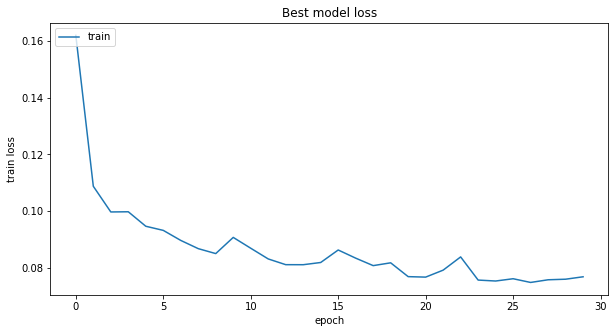

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_loss'], label='train')
plt.title('Best model loss')
plt.xlabel('epoch')
plt.ylabel('train loss')
#plt.xticks(range(len(best_model_history['loss'])))
plt.legend(loc='upper left')
plt.show()

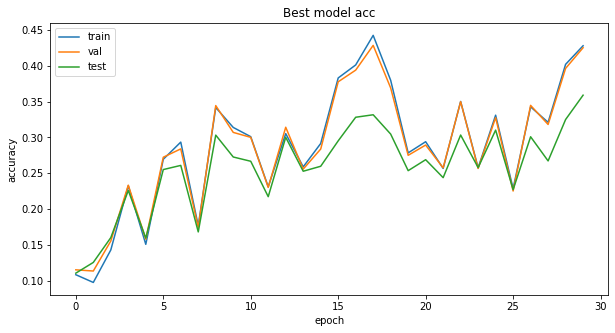

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_acc'], label='train')
plt.plot(best_model_history['val_acc'], label='val')
plt.plot(best_model_history['test_acc'], label='test')
plt.title('Best model acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.xticks(range(len(best_model_history['acc'])))
plt.legend(loc='upper left')
plt.show()

#Train and evaluate ML models
In this section are evaluated the performance of some ML models to see the real improvement in using a GNN model.

Also in this case a fine tuning is performed to evaluate only the best configuration of parameters for each model.

In [ ]:
# X_train and X_test contains the node features
# X_train combines both train and validation splits in order to perform crossvalidation
X_train = pd.DataFrame(data.x[split_idx['train']].detach().numpy())
X_test = pd.DataFrame(data.x[split_idx['test']].detach().numpy())
print(f'X_train\tshape: {X_train.shape}\nX_test\tshape: {X_test.shape}')

X_train	shape: (196615, 100)
X_test	shape: (2213091, 100)


In [ ]:
# y_train and y_test contains the node labels
y_train = data.y[split_idx['train']].detach().numpy().reshape(-1,)
y_test = data.y[split_idx['test']].detach().numpy().reshape(-1,)
print(f'y_train\tshape: {y_train.shape}\ny_test\tshape: {y_test.shape}')

y_train	shape: (196615,)
y_test	shape: (2213091,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Labels for the models
model_lbls = [
    'lr',   # Logistic Regressor
    'rf',   # Random Forest
    'xgb',  # eXtreme Gradient Boost
]

# Set the parameters to be explored for each classifier
tuned_param_lr = [
    {
        'solver': ['lbfgs'],
    },
]
tuned_param_rf = [
    {
        'max_depth': [100],
    },
]
tuned_param_xgb = [
    {
        'objective': ['multi:softmax'],
        'tree_method': ['gpu_hist'],
    },
]

# Set the models to be fitted specifying name, estimator and parameter structure
models = {
    'lr': {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(),
        'param': tuned_param_lr,
    },
    'rf': {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(), 
        'param': tuned_param_rf,
    },
    'xgb':{
        'name': 'XGBoost',
        'estimator': XGBClassifier(),
        'param': tuned_param_xgb,
    }
}

# Scores to be explored
scores = [
    'precision', 
#    'recall',
]

In [ ]:
def print_results(model):    
    print("Best parameters set found on train set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    best_score = 0
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, param in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, param))
        if mean > best_score:
          best_score = mean
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    y_pred = model.predict(X_test)
    print(f'Accuracy on test: {accuracy_score(y_test, y_pred)*100:.2f}%')
    return best_score * 100

In [ ]:
for score in scores:
    print("========================================")
    print("# Tuning hyper-parameters for {}".format(score))
    for model in models:
        print("----------------------------------------")
        print("Trying model {}".format(models.get(model)["name"]))
        start = time.time()
        clf = GridSearchCV(models.get(model)["estimator"], models.get(model)["param"], scoring='%s_macro' % score)
        clf.fit(X_train, y_train)
        print_results(clf)
        end = time.time()
        print(f"Time elapsed: {(end - start):.2f}s")